# Temperature prediction using Time Series Analyses

## Goals



In this project, you will create a short-term temperature forecast.

- Get and clean temperature data from www.ecad.eu

- Build a baseline model modelling trend and seasonality

- Plot and inspect the different components of a time series

- Model time dependence of the remainder using an AR model

- Compare the statistical output of different AR models

- Test the remainder for stationarity

- upload your code to GitHub



In [120]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline



from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


from sklearn.metrics import mean_absolute_error


In [23]:
# read data

temp = pd.read_table("../00_data/ECA_blended_custom/TG_STAID002759.txt",
na_values=-9999, skiprows=19,skipinitialspace=True, delimiter=',', parse_dates=[1])
print(temp.columns)
temp[["TG"]] = temp[["TG"]] / 10

temp.head()

Index(['SOUID', 'DATE', 'TG', 'Q_TG'], dtype='object')


,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,2.2,0
1,127488,1876-01-02,2.5,0
2,127488,1876-01-03,0.3,0
3,127488,1876-01-04,-5.8,0
4,127488,1876-01-05,-9.8,0


In [68]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53477 entries, 0 to 53476
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   SOUID   53477 non-null  int64         
 1   DATE    53477 non-null  datetime64[ns]
 2   TG      53282 non-null  float64       
 3   Q_TG    53477 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.6 MB


In [69]:
temp.dropna(inplace=True)

## Generate Stationary series

### Add time features

In [33]:
# make function that cycles through time attrs and then adds a column to the df

def make_time_cols(time_att, time_series):
    
    feature_list = []

    for ta in time_att:
        try:

            dtobj = getattr(time_series, 'dt')

            feature_list.append(pd.Series(getattr(dtobj,ta), name = ta))
        except AttributeError:
            print(f'Time Attribute not present: {ta}')

    return pd.concat(feature_list, axis = 1)

In [93]:
X = temp[["DATE"]]
y = temp["TG"]
time_atts = make_time_cols(time_att= ['year', 'month', 'week', 'dayofyear'], time_series = X.DATE)

X = pd.concat([X, time_atts], axis = 1)


/tmp/ipykernel_210003/1725717165.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  feature_list.append(pd.Series(getattr(dtobj,ta), name = ta))


In [94]:
X

,DATE,year,month,week,dayofyear
0,1876-01-01,1876,1,52,1
1,1876-01-02,1876,1,52,2
2,1876-01-03,1876,1,1,3
3,1876-01-04,1876,1,1,4
4,1876-01-05,1876,1,1,5
...,...,...,...,...,...
53472,2022-05-27,2022,5,21,147
53473,2022-05-28,2022,5,21,148
53474,2022-05-29,2022,5,21,149
53475,2022-05-30,2022,5,22,150


In [95]:
X.describe()

,year,month,week,dayofyear
count,53282.000000,53282.000000,53282.000000,53282.000000
mean,1948.721670,6.509515,26.533126,182.714275
std,42.343699,3.453693,15.084951,105.591561
min,1876.000000,1.000000,1.000000,1.000000
25%,1912.000000,4.000000,13.000000,91.000000
50%,1949.000000,7.000000,26.000000,182.000000
75%,1985.000000,10.000000,40.000000,274.000000
max,2022.000000,12.000000,53.000000,366.000000


## Model Trend and Seasonality


In [101]:
trans = ColumnTransformer([
    ('linear', 'passthrough', ['year']),
    ('oh', OneHotEncoder(drop='first', sparse=True), ['week'])

],
    remainder = 'drop')

detrend = Pipeline([
    ('transform', trans),
    ('model', LinearRegression())
])

detrend.fit(X, y)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('linear', 'passthrough',
                                                  ['year']),
                                                 ('oh',
                                                  OneHotEncoder(drop='first'),
                                                  ['week'])])),
                ('model', LinearRegression())])

Remove trend and seasonality:

In [102]:
y_detrend = y - detrend.predict(X)

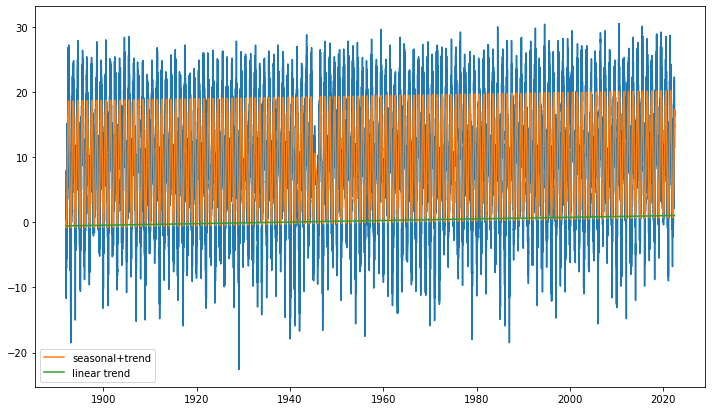

In [142]:
plt.rcParams['figure.figsize'] = (12,7)

t_subs = 365 * 130

plt.plot(X['DATE'][-t_subs:], y[-t_subs:])
plt.plot(X['DATE'][-t_subs:], detrend.predict(X)[-t_subs:], label = 'seasonal+trend')
plt.plot(X['DATE'][-t_subs:], X['year'][-t_subs:] * detrend.named_steps['model'].coef_[0] + detrend.named_steps['model'].intercept_, label = 'linear trend')
plt.legend()

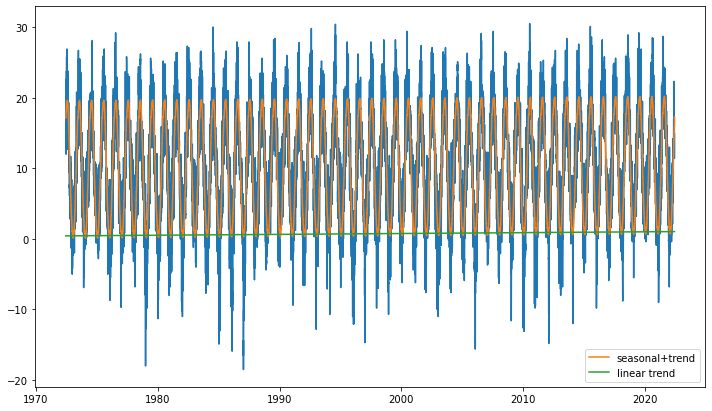

In [137]:
plt.rcParams['figure.figsize'] = (12,7)

t_subs = 365 * 50

plt.plot(X['DATE'][-t_subs:], y[-t_subs:])
plt.plot(X['DATE'][-t_subs:], detrend.predict(X)[-t_subs:], label = 'seasonal+trend')
plt.plot(X['DATE'][-t_subs:], X['year'][-t_subs:] * detrend.named_steps['model'].coef_[0] + detrend.named_steps['model'].intercept_, label = 'linear trend')
plt.legend()

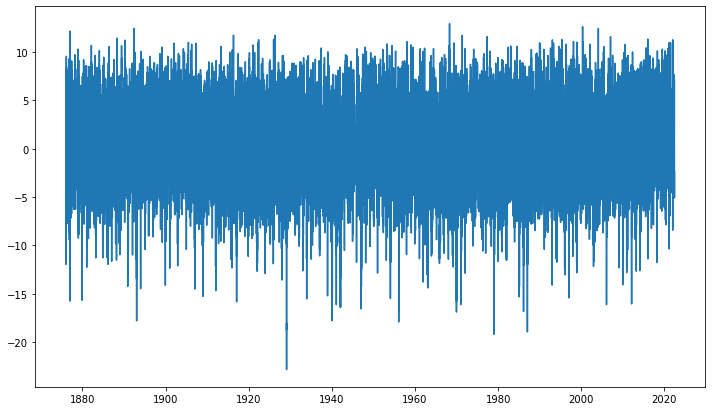

In [106]:
plt.plot(X['DATE'], y_detrend)

## Identify AR / MA orders

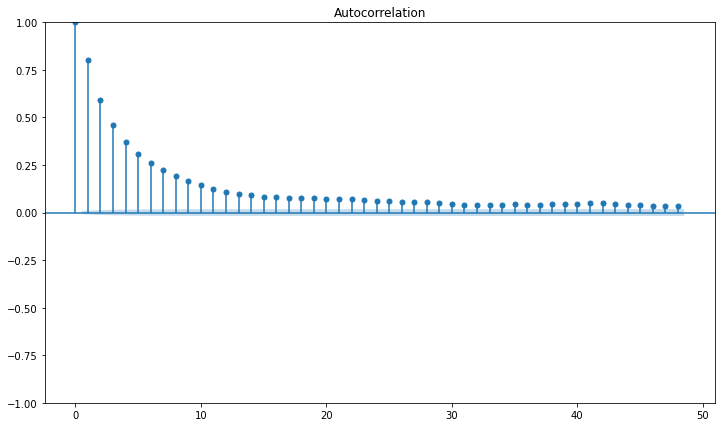

In [143]:
plot = plot_acf(y_detrend)

/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


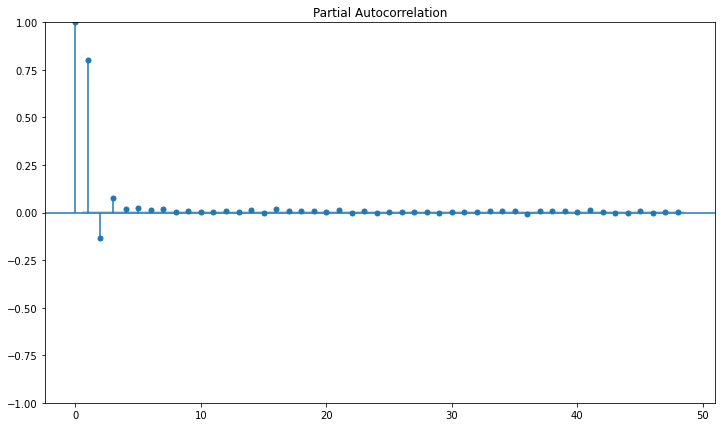

In [144]:
plot = plot_pacf(y_detrend)

Asessment: 

P = 1  
Q = 3

## Generate ARIMA(3,0,1)

In [111]:
from statsmodels.tsa.arima.model import ARIMA

In [112]:
arima = ARIMA(endog= y_detrend, order = (3,0,1)).fit()

/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [113]:
y_arima = arima.predict()

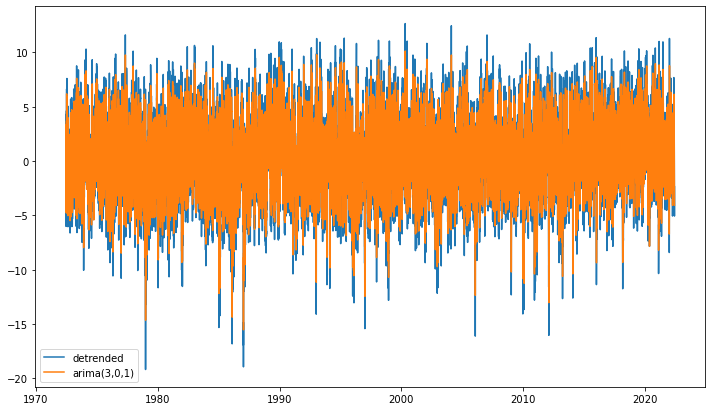

In [138]:
plt.plot(X['DATE'][-t_subs:], y_detrend[-t_subs:], label = 'detrended')
plt.plot(X['DATE'][-t_subs:], y_arima[-t_subs:], label = 'arima(3,0,1)')
plt.legend()

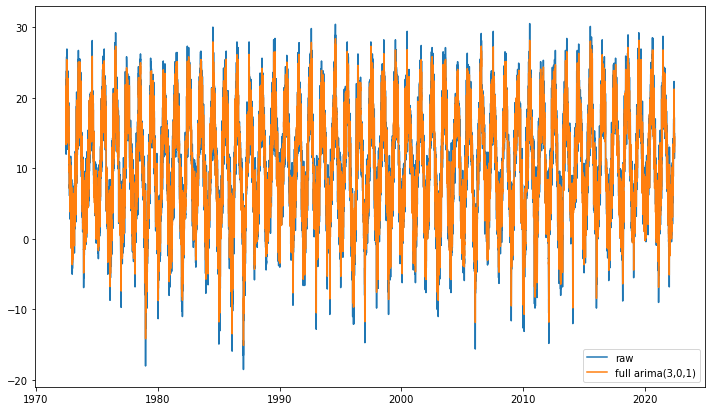

In [139]:
plt.plot(X['DATE'][-t_subs:], y[-t_subs:], label = 'raw')
plt.plot(X['DATE'][-t_subs:], y_arima[-t_subs:] + detrend.predict(X)[-t_subs:], label = 'full arima(3,0,1)')
plt.legend()

## Evaluate

In [141]:
temp_mae = mean_absolute_error(y, y_arima + detrend.predict(X))

print(f"The ARIMA(3,0,1) temperature prediction is on average off by {round(temp_mae,2)} \u2103 for any given day.")


The ARIMA(3,0,1) temperature prediction is on average off by 1.75 ℃ for any given day.


## Compare different ARIMA models

- generate grid $q = [1:3],~p = [1:3]$
- run ARIMA with $q_i$, $p_i$ on detrended
- calculate MAE

In [ ]:
import itertools
def expand_grid(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())



arima_grid = expand_grid(
    {
        'p' : [0,1,2,3],
        'q' : [0,1,2,3]
    
    }
)[model_cols]

new_data

## Forecast with best model

In [49]:
from statsmodels.tsa.tsatools import lagmat 

lagmat(y, maxlag = 3)

array([[ 0. ,  0. ,  0. ],
       [ 2.2,  0. ,  0. ],
       [ 2.5,  2.2,  0. ],
       ...,
       [11.4, 14. , 17.2],
       [12. , 11.4, 14. ],
       [12.2, 12. , 11.4]])